# Sequence NLP - Project

## Conext
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected
using hashtag based supervision but such datasets are noisy in terms of labels and
language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in
these requires the availability of contextual tweets.In this hands-on project, the goal is to
build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

## Data Description
The dataset is collected from two news websites, theonion.com and huffingtonpost.com.<br>
This new dataset has the following advantages over the existing Twitter datasets:<br>
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and
informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with
much less noise as compared to Twitter datasets.<br>

Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in
teasing apart the real sarcastic elements<br>

Content: Each record consists of three attributes<br>
is_sarcastic: 1 if the record is sarcastic otherwise 0<br>
headline: the headline of the news article<br>
article_link: link to the original news article. Useful in collecting supplementary data<br>

Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

## Project Objective
Build a sequential NLP classifier which can use input text parameters
to determine the customer sentiments.

## Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!pip install autocorrect

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
#from autocorrect import Speller
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten
from functools import partial
from sklearn.metrics import confusion_matrix,classification_report

In [5]:
# Set the random seet
np.random.seed(1)
tf.random.set_seed(1)

## Load Dataset

In [6]:
# Load the data from first file
df = pd.read_json("/content/drive/MyDrive/Colab Notebooks/NLP/Sequential_NLP /Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [7]:
df.shape

(26709, 3)

**Observation:**
- There are 26709 headlines and 3 attributes in first dataset.

In [8]:
# Load the data from second file
dfv2 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/NLP/Sequential_NLP /Sarcasm_Headlines_Dataset_v2.json", lines=True)
dfv2.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [9]:
dfv2.tail()

,is_sarcastic,headline,article_link
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...
28618,1,dad clarifies this not a food stop,https://www.theonion.com/dad-clarifies-this-no...


In [10]:
dfv2.shape

(28619, 3)

**Observation:**
- There are 28619 headlines and 3 attributes in second dataset.

In [11]:
# Combine first and second dataset into single dataframe
dffinal = pd.concat([df,dfv2], ignore_index=True)

In [12]:
dffinal.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [13]:
dffinal.tail()

,article_link,headline,is_sarcastic
55323,https://www.theonion.com/jews-to-celebrate-ros...,jews to celebrate rosh hashasha or something,1
55324,https://local.theonion.com/internal-affairs-in...,internal affairs investigator disappointed con...,1
55325,https://www.huffingtonpost.com/entry/andrew-ah...,the most beautiful acceptance speech this week...,0
55326,https://www.theonion.com/mars-probe-destroyed-...,mars probe destroyed by orbiting spielberg-gat...,1
55327,https://www.theonion.com/dad-clarifies-this-no...,dad clarifies this not a food stop,1


In [14]:
dffinal.shape

(55328, 3)

**Observation:**
- There are 55328 headlines and 3 attributes in final dataset.

## Data Analysis

In [15]:
dffinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


**Observation:**
- There is no missing value in dataset. 
- Datatype is object for article_link and headline.
- Datatype is int64 for is_sarcastic.

In [16]:
dffinal.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
article_link,55328,28617,https://www.huffingtonpost.comhttp://nymag.com...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
headline,55328,28503,"'no way to prevent this,' says only nation whe...",20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_sarcastic,55328,NaN,NaN,NaN,0.458321,0.498264,0,0,0,1,1


**Observation:**
- There are two two values in is_sarcastic. It is binary classification. 

In [17]:
dffinal["is_sarcastic"].value_counts()

0    29970
1    25358
Name: is_sarcastic, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


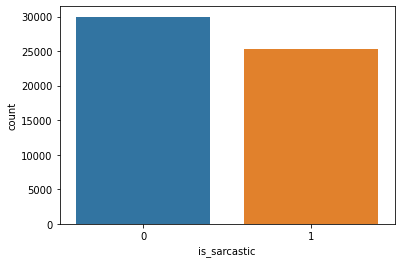

In [18]:
sns.countplot(dffinal["is_sarcastic"])

**Observation:**
- There are 29970 non-sarcastic and 25358 sarcastic headlines in dataset. 

In [19]:
# Define function which takes full article link and extract string with website name
def extract_website(link):
       return link.split('//')[1].split('.com')[0].replace('www.', "")


In [20]:
# Apply extract_website func to df article_link and create new column with website name
dffinal['website'] = dffinal['article_link'].apply((lambda x: extract_website(x)))

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

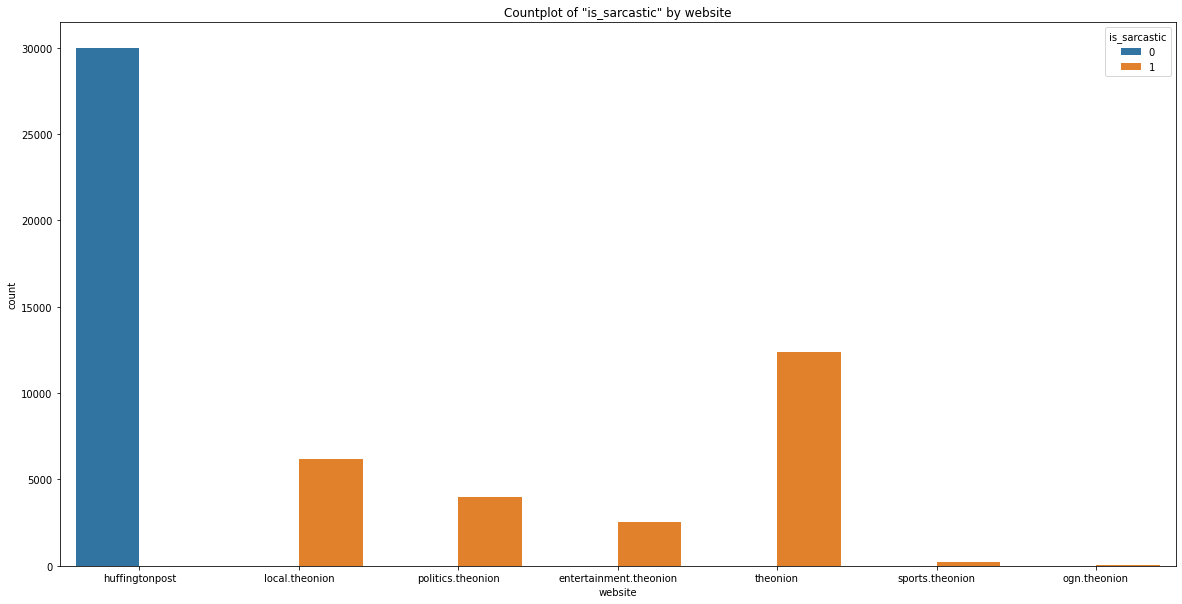

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(data=dffinal, x = 'website', hue='is_sarcastic').set_title('Countplot of "is_sarcastic" by website')
plt.xticks(rotation=0)

**Observation:**
- There are more headlines from huffingtonpost website.

In [22]:
# Add new column 'headline_len': Text length of headline 
dffinal['headline_len'] = dffinal['headline'].apply(lambda x: len(x.split(' ')))

In [23]:
dffinal.sort_values(by='headline_len', ascending=False).head()

,article_link,headline,is_sarcastic,website,headline_len
34011,https://www.theonion.com/hot-wheels-ranked-num...,hot wheels ranked number one toy for rolling d...,1,theonion,151
51524,https://www.theonion.com/elmore-leonard-modern...,"elmore leonard, modern prose master, noted for...",1,theonion,39
15247,https://www.theonion.com/elmore-leonard-modern...,"elmore leonard, modern prose master, noted for...",1,theonion,39
50307,https://www.huffingtonpost.com/entry/self-hate...,occasionally you realize someone you thought w...,0,huffingtonpost,38
21783,https://www.huffingtonpost.com/entry/self-hate...,occasionally you realize someone you thought w...,0,huffingtonpost,38


In [24]:
dffinal['headline_len'].describe()

count    55328.000000
mean         9.953369
std          3.288667
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max        151.000000
Name: headline_len, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


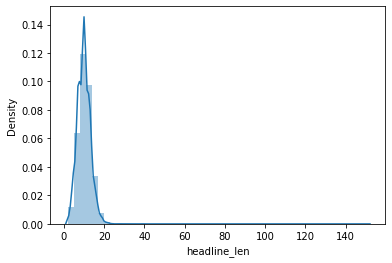

In [25]:
sns.distplot(dffinal['headline_len'])

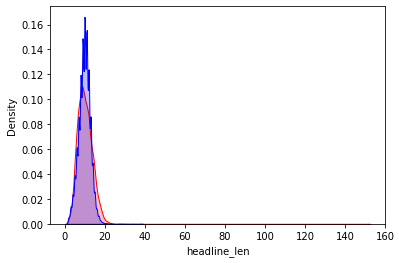

In [26]:
sns.kdeplot(dffinal.loc[(dffinal['is_sarcastic']==1), 
            'headline_len'], color='r', shade=True, Label='Sarcastic') 
sns.kdeplot(dffinal.loc[(dffinal['is_sarcastic']==0), 
            'headline_len'], color='b', shade=True, Label='Non-Sarcastic') 

**Observation:**
- The maximum number of words in the sentence is 151. 
- Avg 10 numbber of words in the sentences. 
- 50% of headlines contain 10 nuumber of words in the sentence. 

## Preprocessing

In [27]:
# To convert lower case
dffinal['headline_clean']=dffinal['headline'].str.lower()

# To remove the Hashtags from the text
dffinal['headline_clean']=dffinal['headline_clean'].apply(lambda x:re.sub(r'\B#\S+','',x))

# To remove the links from the text
dffinal['headline_clean']=dffinal['headline_clean'].apply(lambda x:re.sub(r"http\S+", "", x))

# To remove the Special characters from the text 
dffinal['headline_clean']=dffinal['headline_clean'].apply(lambda x:' '.join(re.findall(r'\w+', x)))

# To substitute the multiple spaces with single spaces
#dffinal['headline_clean']=dffinal['headline_clean'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# To remove all the single characters in the text
#dffinal['headline_clean']=dffinal['headline_clean'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

dffinal['headline_clean']=dffinal['headline_clean'].apply(lambda x:re.sub('@[^\s]+','',x))

In [28]:
dffinal.head()

,article_link,headline,is_sarcastic,website,headline_len,headline_clean
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost,12,former versace store clerk sues over secret bl...
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14,the roseanne revival catches up to our thorny ...
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,local.theonion,14,mom starting to fear son s web series closest ...
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,politics.theonion,13,boehner just wants wife to listen not come up ...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11,j k rowling wishes snape happy birthday in the...


In [29]:
#spell = Speller(lang='en')

#dffinal['headline_clean']=dffinal['headline_clean'].apply(lambda x: spell(x))

## Set the Parameters

In [30]:
vocab_size = 38000      # Vocabulary 
max_length = 151        # Max length
embedding_size = 300    # Embedding size

## Tokenization and Get Features & Label

In [31]:
# Apply the tokenization for each word
tokenizer = Tokenizer(num_words=vocab_size)

tokenizer.fit_on_texts(dffinal['headline_clean'].tolist())

In [32]:
#Verify the indices 
print(tokenizer.word_index)

{'to': 1, 'of': 2, 'the': 3, 's': 4, 'in': 5, 'for': 6, 'a': 7, 'on': 8, 'and': 9, 'with': 10, 'trump': 11, 'is': 12, 'new': 13, 'man': 14, 'from': 15, 'at': 16, 'you': 17, 't': 18, 'it': 19, 'about': 20, 'by': 21, 'this': 22, 'after': 23, 'out': 24, 'up': 25, 'that': 26, 'be': 27, 'he': 28, 'how': 29, 'as': 30, 'not': 31, 'what': 32, 'can': 33, 'are': 34, 'your': 35, 'his': 36, 'who': 37, 'just': 38, 'all': 39, 'has': 40, 'will': 41, 'year': 42, 'more': 43, 'one': 44, 'report': 45, 'into': 46, 'have': 47, 'i': 48, 'woman': 49, 'why': 50, 'over': 51, 'day': 52, 'area': 53, 'u': 54, 'donald': 55, 'says': 56, 'time': 57, 'first': 58, 'no': 59, 'like': 60, 'obama': 61, 'get': 62, 'people': 63, 'her': 64, 'women': 65, 'old': 66, 'off': 67, 'life': 68, 'world': 69, 'nation': 70, 'we': 71, 'an': 72, 'now': 73, 'house': 74, 'they': 75, 'white': 76, 'still': 77, 'back': 78, 'make': 79, 'clinton': 80, 'was': 81, 'than': 82, 'down': 83, 'my': 84, 'if': 85, '5': 86, 'she': 87, 'when': 88, 'family

In [33]:
# Get the features with indices
X = tokenizer.texts_to_sequences(dffinal['headline_clean'])

In [34]:
dffinal['headline_clean'][0]

'former versace store clerk sues over secret black code for minority shoppers'

In [35]:
# Verify the indices for above sentence
X[0]

[324, 14946, 625, 3243, 2474, 51, 377, 96, 2172, 6, 2774, 8733]

In [36]:
# Add padding to bring all the sentences in same length
X = pad_sequences(X, maxlen=max_length, padding='pre')

In [37]:
print(X)

[[    0     0     0 ...     6  2774  8733]
 [    0     0     0 ...   253     9  1048]
 [    0     0     0 ...    47     1 10950]
 ...
 [    0     0     0 ...     7   712  1869]
 [    0     0     0 ...  2512   833  6508]
 [    0     0     0 ...     7   266   186]]


In [38]:
# Get the target label
y = np.asarray(dffinal['is_sarcastic'])

In [39]:
print(y)

[0 0 1 ... 0 1 1]


## Get Vocabulary Size

In [40]:
num_words=len(tokenizer.word_index)
print (num_words)

26314


## Create a weight matrix using GloVe embeddings

In [41]:
embedding_file = '/content/drive/MyDrive/Colab Notebooks/NLP/Sequential_NLP /glove.6B.300d.txt'
embedding = {}

for o in open(embedding_file, encoding='cp437'):
    word = o.split(" ")[0]
    #print(word)
    embd = o.split(" ")[1:]
    embd = np.array(embd, dtype='float32')
    #print(embd)
    embedding[word] = embd

In [42]:
#Initialize embedding matrix to all zeros
embedding_matrix = np.zeros((num_words+1, #Vocablury size + 1
                             300))

for word, i in tokenizer.word_index.items():
  embedding_vector = embedding.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [43]:
len(embedding)

400000

## Model Building

In [44]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)

In [45]:
tf.keras.backend.clear_session()
# Intialize the model
model = Sequential()

# Add embedding layer
model.add(Embedding(input_dim=num_words+1, 
                    output_dim=embedding_size, 
                    weights = [embedding_matrix], 
                    input_length=max_length))

# Add LSTM with Birectional
model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Add Flatter layer
model.add(Flatten())

# Add Dense layers with Relu activation function
model.add(Dense(300, activation='relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation= 'relu'))

# Add dropout layer to reduce the overfit
model.add(Dropout(0.5))

# Add output layer with Sigmoid activation function as it is binary classification
model.add(Dense(1, activation="sigmoid"))

In [46]:
# Compile the model
model.compile(loss="binary_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             metrics=["accuracy"])

In [47]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 151, 300)          7894500   
_________________________________________________________________
bidirectional (Bidirectional (None, 151, 256)          439296    
_________________________________________________________________
flatten (Flatten)            (None, 38656)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               11597100  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [48]:
batch_size = 32
epochs = 100

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train the model
training_history = model.fit(X_train, y_train, 
                             batch_size=batch_size, 
                             epochs=epochs, 
                             validation_data=(X_test, y_test),
                             callbacks= [callback]
                             )

Epoch 1/100
1384/1384 [==============================] - 43s 26ms/step - loss: 0.4043 - accuracy: 0.8150 - val_loss: 0.2951 - val_accuracy: 0.8722
Epoch 2/100
1384/1384 [==============================] - 36s 26ms/step - loss: 0.2253 - accuracy: 0.9120 - val_loss: 0.1996 - val_accuracy: 0.9201
Epoch 3/100
1384/1384 [==============================] - 36s 26ms/step - loss: 0.1219 - accuracy: 0.9570 - val_loss: 0.1571 - val_accuracy: 0.9450
Epoch 4/100
1384/1384 [==============================] - 36s 26ms/step - loss: 0.0617 - accuracy: 0.9792 - val_loss: 0.1523 - val_accuracy: 0.9528
Epoch 5/100
1384/1384 [==============================] - 36s 26ms/step - loss: 0.0323 - accuracy: 0.9900 - val_loss: 0.1496 - val_accuracy: 0.9619
Epoch 6/100
1384/1384 [==============================] - 36s 26ms/step - loss: 0.0206 - accuracy: 0.9934 - val_loss: 0.1462 - val_accuracy: 0.9661
Epoch 7/100
1384/1384 [==============================] - 36s 26ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0

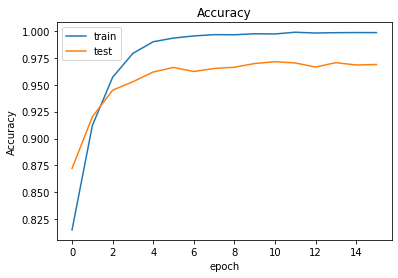

In [49]:
# Plot the graph for Accuracy vs Val Accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Observation:**

Above graph Accuracy vs Epoch shows that finaly accuracy of training set (0.9985) is higher than test set(0.9688) accuracy in 16th epoch.

In [ ]:
# Plot the graph for Loss vs Val Loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Observation:**

Above graph Loss vs Epoch shows that training set loss (0.0049) is less than test set(0.2288) loss in final epoch. Accuracy and Loss graphs are shows that it is good fit model.

## Model Evaluation

In [51]:
model_eval_score = model.evaluate(X_test, y_test)

346/346 [==============================] - 3s 9ms/step - loss: 0.1462 - accuracy: 0.9661


In [52]:
# Predict the label for test set
y_pred= model.predict(X_test)

In [53]:
prediction_clf = (y_pred > 0.5)

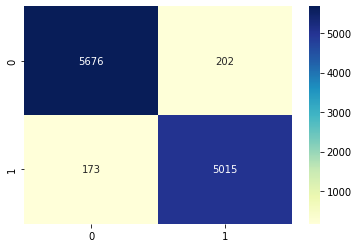

In [54]:
sns.heatmap(confusion_matrix(y_test, prediction_clf),annot=True,fmt='',cmap='YlGnBu')

In [55]:
print(classification_report(y_test,prediction_clf))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5878
           1       0.96      0.97      0.96      5188

    accuracy                           0.97     11066
   macro avg       0.97      0.97      0.97     11066
weighted avg       0.97      0.97      0.97     11066



**Observation:**
- Model predicted 97% (10691/11066) correctly.
- **True Negative:** Model predicted correctly for 5676 headline sentences are not sarcastic.
- **True Positive:** Model predicted correctly for 5015 headline sentences are sarcastic.
- **False Positive:** Model predicted 202 headline sentences are sarcastic but not in real case.
-**False Negative:** Model predicted 173 headline sentences are not sarcastic but those headlines are are sarcastic in real case. 
- Precision score of 97% implies model predicted total 5849 headlines are not sarcastic but prediction is correct for 5676 headlines and incorrect for 173 headlines. 
-Precision 96% shows model predicted total 5217 headlines are sarcastic but prediction is correct for 5015 headlines and remaining 202 headlines are not sarcastic in reality.
- Overall accuracy is 97% and f1-score also above 96%. 
- It is very good model. 

## Using Transformers

In [56]:
# Installing transformers
!pip install transformers

     |████████████████████████████████| 2.8 MB 7.2 MB/s 
     |████████████████████████████████| 52 kB 2.0 MB/s 
     |████████████████████████████████| 636 kB 51.0 MB/s 
     |████████████████████████████████| 895 kB 67.5 MB/s 
     |████████████████████████████████| 3.3 MB 51.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [98]:
# Import libraries 
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

In [99]:
# Initialize the tokernizer from pretrained model. It gives end-to-end tokenization for punctuation and word piece
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [100]:
# Get independent and target variables
X = dffinal['headline_clean'].tolist()
y = dffinal['is_sarcastic'].tolist()

In [101]:
# Split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
# Apply the tockenizer on train and test set
train_encodings = tokenizer(X_train, padding=True)['input_ids']
test_encodings = tokenizer(X_test,  padding=True)['input_ids']

In [103]:
# Load the pretrained model
model1 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 1)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_80', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [104]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5)
model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [105]:
# Train the model
history = model1.fit(train_encodings, y_train, epochs = 20, batch_size = 32, validation_data = (test_encodings, y_test))

Epoch 1/20
1384/1384 [==============================] - 787s 564ms/step - loss: 0.4234 - accuracy: 0.8154 - val_loss: 0.3213 - val_accuracy: 0.8674
Epoch 2/20
1384/1384 [==============================] - 774s 559ms/step - loss: 0.3037 - accuracy: 0.8936 - val_loss: 0.2803 - val_accuracy: 0.9030
Epoch 3/20
1384/1384 [==============================] - 764s 552ms/step - loss: 0.2176 - accuracy: 0.9300 - val_loss: 0.2462 - val_accuracy: 0.9257
Epoch 4/20
1384/1384 [==============================] - 754s 545ms/step - loss: 0.1649 - accuracy: 0.9546 - val_loss: 0.1796 - val_accuracy: 0.9423
Epoch 5/20
1384/1384 [==============================] - 748s 540ms/step - loss: 0.1187 - accuracy: 0.9715 - val_loss: 0.2382 - val_accuracy: 0.9517
Epoch 6/20
1384/1384 [==============================] - 745s 538ms/step - loss: 0.1068 - accuracy: 0.9768 - val_loss: 0.2223 - val_accuracy: 0.9591
Epoch 7/20
1384/1384 [==============================] - 741s 535ms/step - loss: 0.1224 - accuracy: 0.9801 - val_

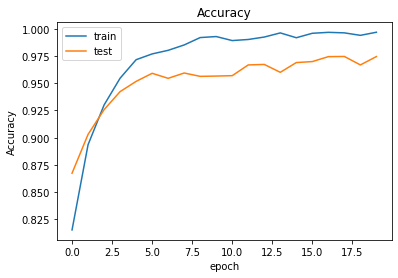

In [106]:
# Plot the graph for Accuracy vs Val Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Observation:**

Above graph Accuracy vs Epoch shows that finaly accuracy of training set (0.9967) is slightly higher than test set(0.9744) accuracy in 20th epoch. 

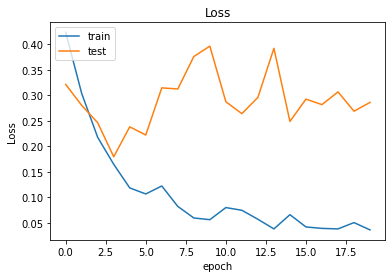

In [107]:
# Plot the graph for Loss vs Val Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Observation:**

Above graph Loss vs Epoch shows that training set loss (0.0364) is higher than test set( 0.2861) loss in final epoch. Accuracy and Loss graphs are shows that it is good fit model.

In [108]:
model_eval_score = model1.evaluate(test_encodings, y_test)

346/346 [==============================] - 19s 55ms/step - loss: 0.2861 - accuracy: 0.9744


In [109]:
y_pred_tf= model1.predict(test_encodings)

In [110]:
pred_clf = (y_pred_tf[0] > 0.5)
#y_pred_tf = np.argmax(y_pred_tf,axis=1)

In [111]:
confusion_matrix(y_test, pred_clf)

array([[5791,   87],
       [ 196, 4992]])

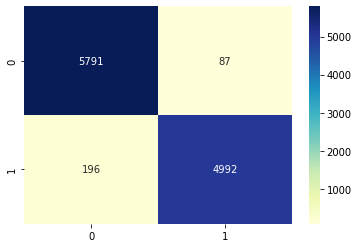

In [112]:
sns.heatmap(confusion_matrix(y_test, pred_clf),annot=True,fmt='',cmap='YlGnBu')

In [113]:
print(classification_report(y_test,pred_clf))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5878
           1       0.98      0.96      0.97      5188

    accuracy                           0.97     11066
   macro avg       0.98      0.97      0.97     11066
weighted avg       0.97      0.97      0.97     11066



**Observation:**
- Model predicted 97% (10783/11066) correctly.
- **True Negative:** Model predicted correctly for 5791 headline sentences are not sarcastic.
- **True Positive:** Model predicted correctly for 4992 headline sentences are sarcastic.
- **False Positive:** Model predicted 87 headline sentences are sarcastic but not in real case.
- **False Negative:** Model predicted 196 headline sentences are not sarcastic but those headlines are are sarcastic in real case. 
- Precision score of 97% implies model predicted total 5987 headlines are not sarcastic but prediction is correct for 5791 headlines and incorrect for 196 headlines. 
-Precision 98% shows model predicted total 5079 headlines are sarcastic but prediction is correct for 4992 headlines and remaining 87 headlines are not sarcastic in reality.
- Overall accuracy is 97% and f1-score also above 97%. 
- It is very good model. 

### Conclusion:
- Accuracy is 97% for both models. Both models are good model. 

# End Project